# Assignment 3: Convolutional Neural Networks (CNNs)


We first import all we need. These modules help us loading dataset and implementing our deep CNNs.

In [1]:
# this is used to include model diagram in this file. It is not related to the implementation
from IPython.display import Image

# torch and its modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np


## Question 1: Making Dataset from CIFAR-10
To make our dataset, we first load CIFAR-10.

In [2]:
# We define the transform: this make the dataset into tensors and normalize it properly
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# let's now load CIFAR-10 train and test datasets
train_set = DS.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = DS.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Play around with CIFAR-10
We may now take a look at the datast properties.

In [3]:
# Print size of the sets
print(len(train_set))
print(len(test_set))
# Check a data sample
print(train_set[0])
# print the label 
print(train_set[0][1])

# print classes
print(train_set.class_to_idx)


50000
10000
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0

To show an image, you may use the following function.

In [4]:
def imshow(img):
    # remove the impact of normalization
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

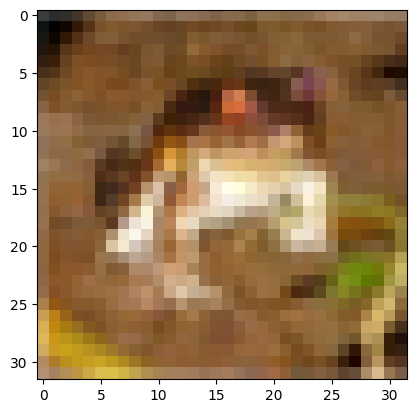

In [5]:
# use imshow() to look into a sample image
imshow(train_set[0][0])

### Make Training and Test Subsets
We first write the function `class_extract` that gets a dataset and a list of classes and returns a subset of dataset that include only the data-points of that class.

In [6]:
def class_extract(cls_list, dataset):
    # initial values
    indx_set = []
    label_set = {}

    # we want later to rewrite the classes
    new_labels = {cls: i for i, cls in enumerate(cls_list)}

    # go through dataset and find points whose labels are in cls_list
    for indx, data in enumerate(dataset):
        if data[1] in cls_list:
            indx_set.append(indx)
            label_set[indx] = new_labels[data[1]]

    # give data-points of the subset new label
    # for instance: we set now cat to class 0 and dog to class 1
    for indx in indx_set:
        dataset.targets[indx] = label_set[indx]

    subset = Subset(dataset, indx_set)
    return subset

We may now try our implementation

In [7]:
cls_list = [3, 5] ## COMPLETE ## find it using .class_to_idx # You may give it as a dictionary
train_subset = class_extract(cls_list, train_set)
test_subset = class_extract(cls_list, test_set)

Now, let's check the size of this reduced dataset.

In [8]:
# print the size of test and train subsets

print(len(train_subset))
print(len(test_subset))

# you may also use imshow() to take a look at the set

10000
2000


### Load Training and Test Datasets as Mini-Batches
We now use the subsets to make our training and test datasets.

Use `DataLoader` to load the training and test datasets as sequences of mini-batches with batch size 100. Do not forget to set option `shuffle = True` when you use DataLoader.

In [9]:
batch_size = 100 
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

Confirm that the number of mini-batches in iterators `train_loader` and `test_loader` matches what you expect.

In [10]:
# print the size of loaders and compare to what you expect
print(len(train_loader))
print(len(test_loader))

100
20


## Question 2: Implementing Plain CNN
The diagram of the model is given below. You may first try playing with `nn.Conv2d` and `nn.MaxPool2d` to get ready for implementation.

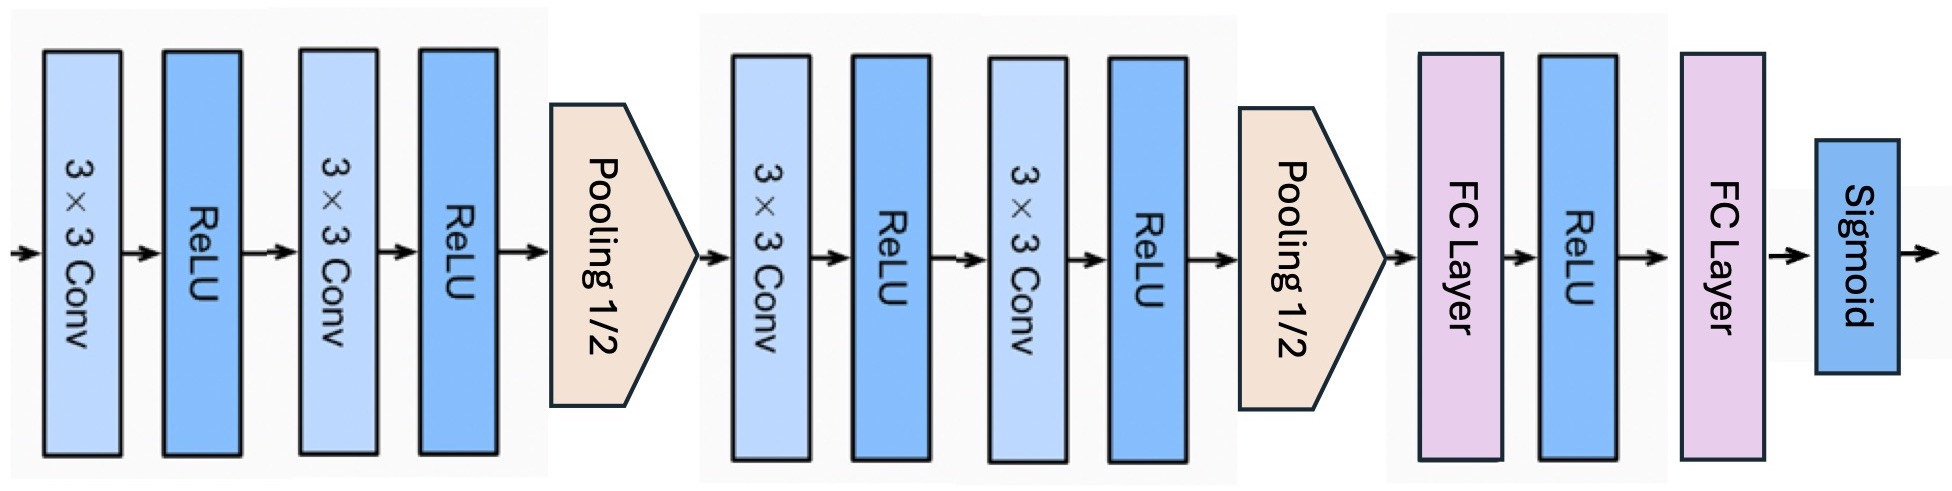

In [10]:
Image("CNN.jpg")

### Implementing the Plain CNN

In [11]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        
        ## COMPLETE ## using nn.Conv2d, nn.MaxPool2d, nn.ReLU(), nn.Sigmoid() and nn.Linear
        # Layer 1: 3x3 Conv (3->32, no padding, stride 1) -> ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Layer 2: 3x3 Conv (32->32, no padding, stride 1) -> ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Layer 3: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 4: 3x3 Conv (32->64, no padding, stride 1) -> ReLU
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        
        # Layer 5: 3x3 Conv (64->64, no padding, stride 1) -> ReLU
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        
        # Layer 6: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 7: Fully-Connected (1600->128) -> ReLU
        self.fc7 = nn.Linear(5 * 5 * 64, 128)
        self.relu7 = nn.ReLU()
        
        # Layer 8: Fully-Connected (128->1) -> Sigmoid (binary classification)
        self.fc8 = nn.Linear(128, 1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        ## COMPLETE ##
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool3(x)
        
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = self.pool6(x)
        
        # Flatten
        x = x.view(-1, 5 * 5 * 64)
        
        x = self.relu7(self.fc7(x))
        x = self.sigmoid8(self.fc8(x))
        
        return x
        return ## COMPLETE ##

### Implementing the Test Function

When implementing, we could use the variable `device` that specifies the device on which the computation is carried out. You may look at the following sample code.

In [ ]:
# We may choose a GPU if we have one on our machine
if torch.backends.cuda.is_built():
  # if we have cuda
  # usually on Windows machines with GPU
  device = "cuda"
elif torch.backends.mps.is_built():
  # if we have MPS
  # usually on MAC
  device = "mps"
else:
  # if not we should use our CPU
  device = "cpu"



cuda


In [14]:
def test(model: myCNN, loss_function, device):
    
    # we first move our model to the configured device
    model = model.to(device = device)

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for test
    with torch.no_grad():
        risk = 0
        accuracy = 0

        # here we are only evaluating the model
        model.eval()

        # loop over test mini-batches
        for i, (images, labels) in enumerate(test_loader):
            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            labels = labels.view(-1, 1).float()

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # determine the class of output from sigmoid output
            predicted = (outputs >= 0.5).float()

            # compute the fraction of correctly predicted labels
            correct_predict = (predicted == labels).sum() / labels.size(0)

            risk += loss.item()
            accuracy += correct_predict.item()

        # average test risk and accuracy over the whole test dataset
        test_risk = risk / len(test_loader)
        test_accuracy = accuracy / len(test_loader)

    return test_risk, test_accuracy

Use the function to test the untrained CNN via the binary cross-entropy function. 

In [15]:
# Instantiate the class
test_model = myCNN()

loss_function = nn.BCELoss()

# test it
test_risk, test_accuracy = test(test_model, loss_function, device)

print(test_risk, test_accuracy)

0.6939108192920684 0.49999999105930326


### Implementing Training Loop

In [18]:
def train(model, num_epochs, device):

    # we first move our model to the configured device
    model = model.to(device = device)

    # set loss to binary CE
    loss_function = nn.BCELoss()

    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initiate the values
    train_risk = []
    test_risk = []
    test_accuracy = []


    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0

        # tell pytorch that you start training
        model.train()

        # loop over training data
        for i, (images, labels) in enumerate(train_loader):

            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            labels = labels.view(-1, 1).float()

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            

            # one step of gradient descent
            optimizer.step()

        # first we tell pytorch we are doing evaluation (reassure it, as we have already included it in test())
        model.eval()

        # test out model after update by the optimizer
        risk_epoch, accuracy_epoch = test(model, loss_function, device)

        # collect losses and accuracy
        avg_train_risk = risk / len(train_loader)
        train_risk.append(avg_train_risk)
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # we can print a message every second epoch
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Risk: {avg_train_risk:.4f}, Test Risk: {risk_epoch:.4f}, Test Accuracy: {accuracy_epoch:.4f}')
            

    # plot the training and test losses
    plt.plot([i+1 for i in range(num_epochs)], train_risk, label='train')
    plt.plot([i+1 for i in range(num_epochs)], test_risk, label='test')
    plt.legend()
    plt.title('Train and Test Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # plot the test accuracy
    plt.plot([i+1 for i in range(num_epochs)], test_accuracy)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return train_risk, test_risk, test_accuracy

Now, we can train

Epoch [2/20], Train Risk: 0.6087, Test Risk: 0.6011, Test Accuracy: 0.6670
Epoch [4/20], Train Risk: 0.5251, Test Risk: 0.5222, Test Accuracy: 0.7360
Epoch [6/20], Train Risk: 0.4583, Test Risk: 0.4759, Test Accuracy: 0.7645
Epoch [8/20], Train Risk: 0.3839, Test Risk: 0.4638, Test Accuracy: 0.7795
Epoch [10/20], Train Risk: 0.3219, Test Risk: 0.4472, Test Accuracy: 0.8005
Epoch [12/20], Train Risk: 0.2595, Test Risk: 0.4832, Test Accuracy: 0.7905
Epoch [14/20], Train Risk: 0.1724, Test Risk: 0.5487, Test Accuracy: 0.7860
Epoch [16/20], Train Risk: 0.1213, Test Risk: 0.7170, Test Accuracy: 0.7870
Epoch [18/20], Train Risk: 0.0733, Test Risk: 0.9325, Test Accuracy: 0.7815
Epoch [20/20], Train Risk: 0.0741, Test Risk: 0.8647, Test Accuracy: 0.7905


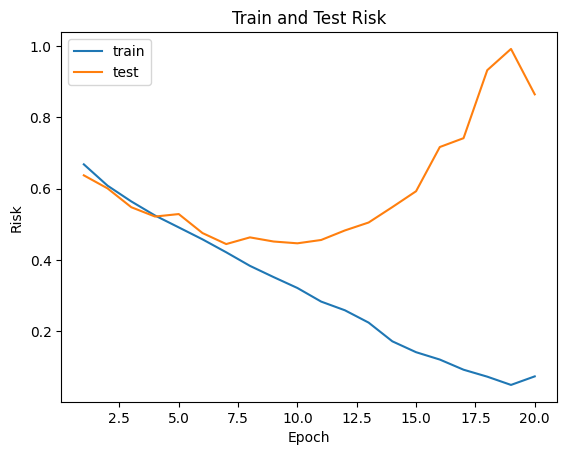

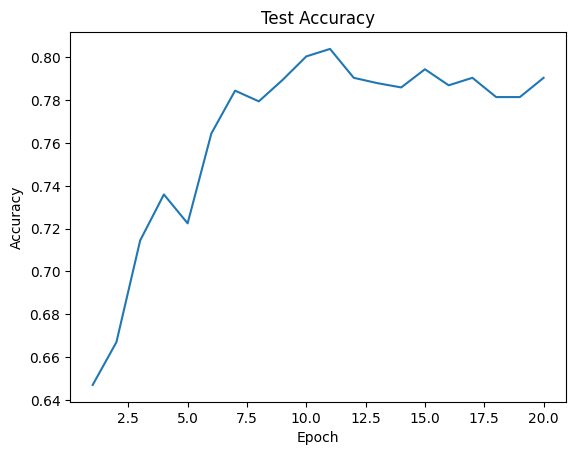

In [19]:
# Instantiate your model
model = myCNN()
num_epochs = 20

train_risk, test_risk, test_accuracy = train(model, num_epochs, device)

### Dropout and Batch Normalization
For this task you may copy class `myCNN` into this new class `myCNN_revised` and add the new blocks.

In [22]:
class myCNN_revised(nn.Module):
    def __init__(self):
        super(myCNN_revised, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout2d(p=0.4)
        
        # Layer 2: 3x3 Conv (32->32, no padding, stride 1) -> ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Layer 3: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 4: 3x3 Conv (32->64, no padding, stride 1) -> ReLU -> BatchNorm2d -> Dropout2d (p=0.4)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout2d(p=0.4)
        
        # Layer 5: 3x3 Conv (64->64, no padding, stride 1) -> ReLU
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        
        # Layer 6: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flattened size = 5*5*64 = 1600 (same as before)
        
        # Layer 7: Fully-Connected (1600->128) -> BatchNorm1d -> ReLU -> Dropout (p=0.4)
        self.fc7 = nn.Linear(5 * 5 * 64, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout(p=0.4)
        
        # Layer 8: Fully-Connected (128->1) -> Sigmoid (binary classification)
        self.fc8 = nn.Linear(128, 1)
        self.sigmoid8 = nn.Sigmoid()
        
    def forward(self, x):
        # L1: Conv -> BN (after activation) -> ReLU -> Dropout (before linear)
        x = self.conv1(x)
        x = self.bn1(self.relu1(x))
        x = self.drop1(x)
        
        # L2: Conv -> ReLU
        x = self.relu2(self.conv2(x))
        
        # L3: Pooling
        x = self.pool3(x)
        
        # L4: Conv -> BN (after activation) -> ReLU -> Dropout (before linear)
        x = self.conv4(x)
        x = self.bn4(self.relu4(x))
        x = self.drop4(x)
        
        # L5: Conv -> ReLU
        x = self.relu5(self.conv5(x))
        
        # L6: Pooling
        x = self.pool6(x)
        
        # Flatten
        x = x.view(-1, 5 * 5 * 64)
        
        # L7: FC -> BN (after activation) -> ReLU -> Dropout (before linear)
        x = self.fc7(x)
        x = self.bn7(self.relu7(x))
        x = self.drop7(x) # add dropout BEFORE the linear operation
        
        # L8: FC -> Sigmoid
        x = self.sigmoid8(self.fc8(x))

        return x

Repeat the training now

Epoch [2/20], Train Risk: 0.6347, Test Risk: 0.5912, Test Accuracy: 0.6870
Epoch [4/20], Train Risk: 0.5757, Test Risk: 0.5368, Test Accuracy: 0.7230
Epoch [6/20], Train Risk: 0.5324, Test Risk: 0.4906, Test Accuracy: 0.7570
Epoch [8/20], Train Risk: 0.4983, Test Risk: 0.4641, Test Accuracy: 0.7595
Epoch [10/20], Train Risk: 0.4685, Test Risk: 0.4445, Test Accuracy: 0.7830
Epoch [12/20], Train Risk: 0.4363, Test Risk: 0.4449, Test Accuracy: 0.7845
Epoch [14/20], Train Risk: 0.4099, Test Risk: 0.4254, Test Accuracy: 0.7880
Epoch [16/20], Train Risk: 0.3833, Test Risk: 0.4458, Test Accuracy: 0.7945
Epoch [18/20], Train Risk: 0.3581, Test Risk: 0.4367, Test Accuracy: 0.7970
Epoch [20/20], Train Risk: 0.3428, Test Risk: 0.4413, Test Accuracy: 0.7830


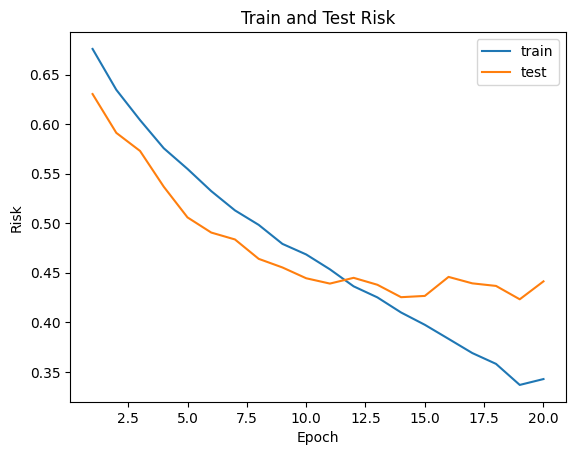

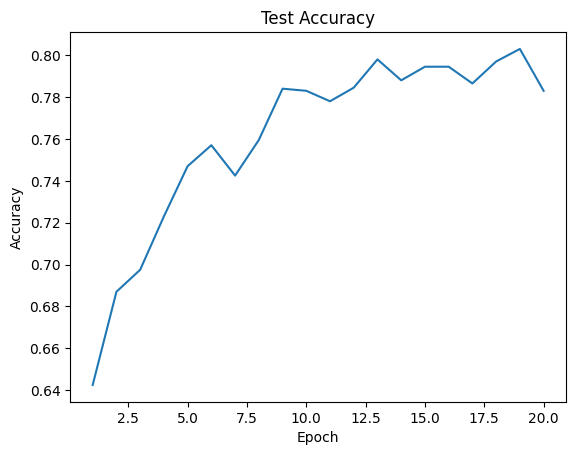

In [23]:
model = myCNN_revised()
num_epochs = 20

train_risk, test_risk, test_accuracy = train(model, num_epochs, device)

## Question 3: Implementing CNN with Skip Connection
The diagram of the model is given below.

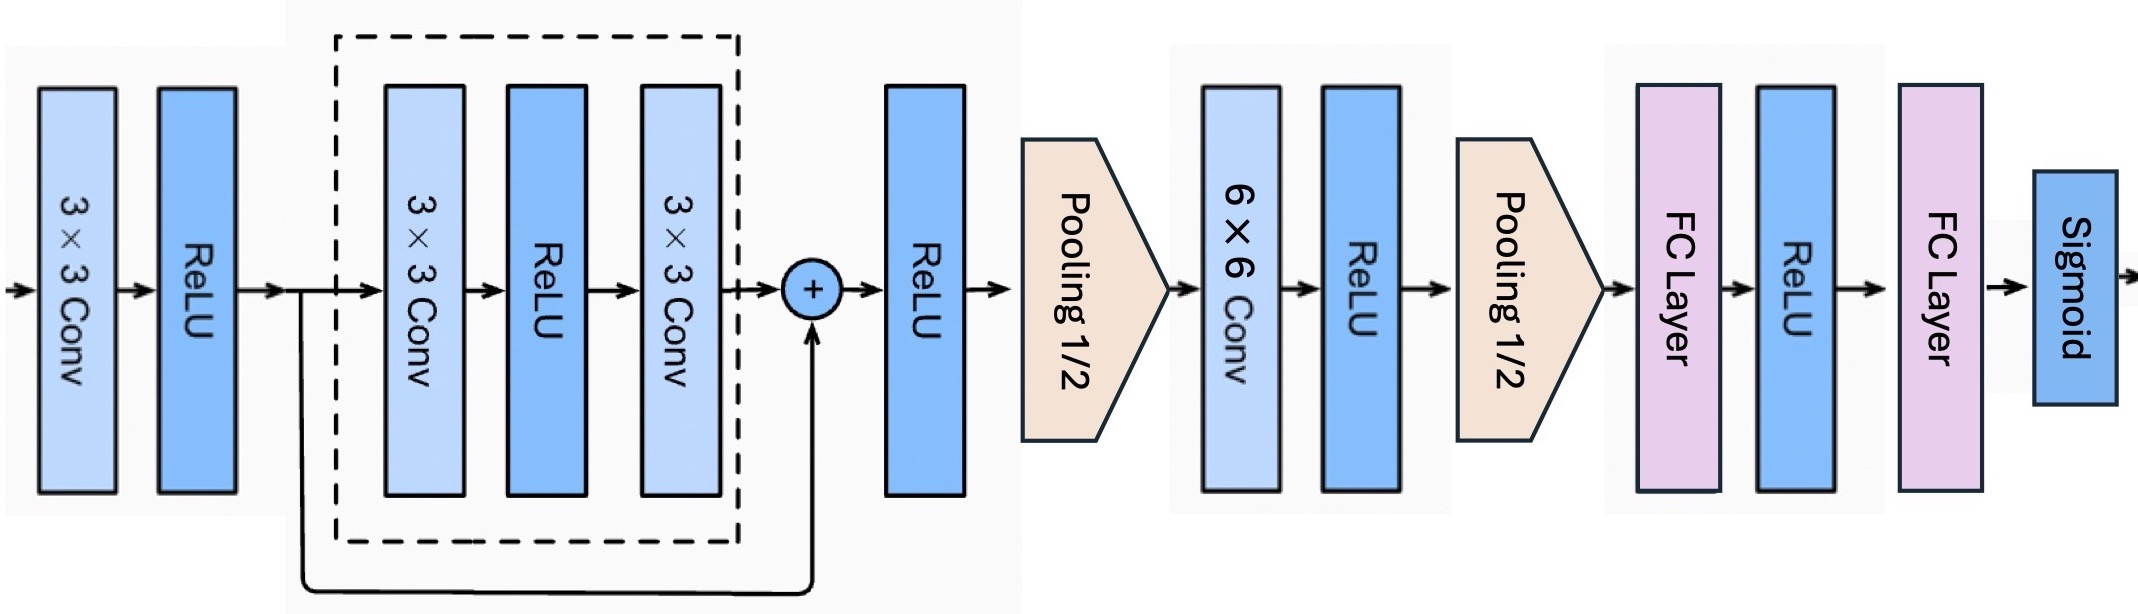

In [13]:
Image('ResNet.jpg')

### Implement the Model
Pay attention to the skip connection. The rest is the same as the plain CNN.

In [24]:
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        # Layer 1: 3x3 Conv (3->32, no padding, stride 1) -> ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Layer 2 (Residual Unit - First Conv): 3x3 Conv (32->32, stride 1, padding 1) -> ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # Layer 3 (Residual Unit - Second Conv): 3x3 Conv (32->32, stride 1, padding 1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # Layer 4: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 5: 6x6 Conv (32->64, no padding, stride 1) -> ReLU
        self.conv5 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        
        # Layer 6: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 7: Fully-Connected (1600->128) -> ReLU
        self.fc7 = nn.Linear(5 * 5 * 64, 128)
        self.relu7 = nn.ReLU()
        
        # Layer 8: Fully-Connected (128->1) -> Sigmoid (binary classification)
        self.fc8 = nn.Linear(128, 1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        # L1: Conv -> ReLU. 
        out1 = self.relu1(self.conv1(x))
        
        # L2: Conv -> ReLU
        out2 = self.relu2(self.conv2(out1))
        # L3: Conv. 
        out3 = self.conv3(out2)
        
        # Skip Connection and ReLU
        out_residual = out1 + out3
        out_residual = self.relu2(out_residual) # Used relu2 as it is the same function nn.ReLU()
        
        # L4: Pooling
        x = self.pool4(out_residual)
        
        # L5: 6x6 Conv -> ReLU
        x = self.relu5(self.conv5(x))
        
        # L6: Pooling
        x = self.pool6(x)
        
        # Flatten
        x = x.view(-1, 5 * 5 * 64)
        
        # L7: FC -> ReLU
        x = self.relu7(self.fc7(x))
        
        # L8: FC -> Sigmoid
        x = self.sigmoid8(self.fc8(x))
        
        return x

### Training our ResNet
We already have the training and test functions inplemented.

Epoch [2/20], Train Risk: 0.5853, Test Risk: 0.5701, Test Accuracy: 0.6925
Epoch [4/20], Train Risk: 0.4686, Test Risk: 0.5042, Test Accuracy: 0.7475
Epoch [6/20], Train Risk: 0.3803, Test Risk: 0.4740, Test Accuracy: 0.7760
Epoch [8/20], Train Risk: 0.3001, Test Risk: 0.4897, Test Accuracy: 0.7860
Epoch [10/20], Train Risk: 0.2008, Test Risk: 0.6093, Test Accuracy: 0.7745
Epoch [12/20], Train Risk: 0.1138, Test Risk: 0.7539, Test Accuracy: 0.7735
Epoch [14/20], Train Risk: 0.0479, Test Risk: 1.0861, Test Accuracy: 0.7710
Epoch [16/20], Train Risk: 0.0382, Test Risk: 1.3657, Test Accuracy: 0.7760
Epoch [18/20], Train Risk: 0.0249, Test Risk: 1.6128, Test Accuracy: 0.7880
Epoch [20/20], Train Risk: 0.0262, Test Risk: 1.8155, Test Accuracy: 0.7735


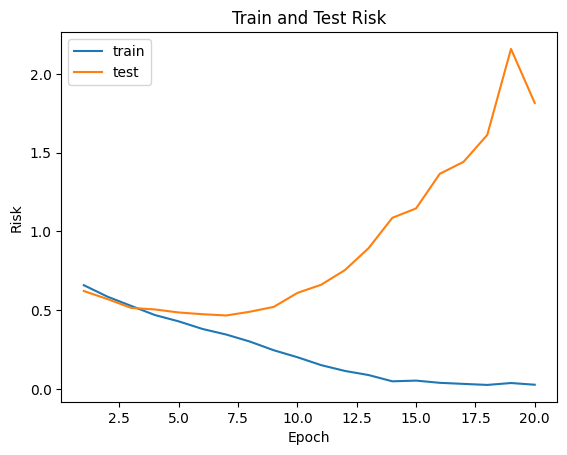

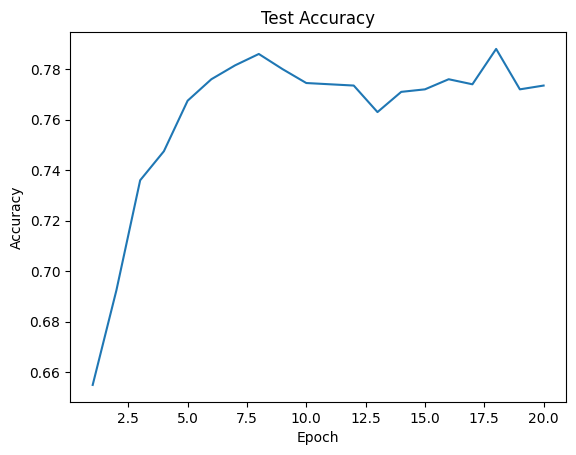

In [25]:
# Make an instant of the class
model = myResNet()
num_epochs = 20

train_risk, train_risk, test_accuracy = train(model, num_epochs, device)

### Droupout and Batch Normalization
Copy class `myResNet` into the class `myResNet_revised` and apply the modifications.

In [26]:
class myResNet_revised(nn.Module):
    def __init__(self):
        super(myResNet_revised, self).__init__()
        # Layer 1: 3x3 Conv (3->32) -> BatchNorm2d -> ReLU -> Dropout2d (p=0.4)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout2d(p=0.4)
        
        # Layer 2 (Residual Unit - First Conv): 3x3 Conv (32->32, stride 1, padding 1) -> BatchNorm2d -> ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        # Layer 3 (Residual Unit - Second Conv): 3x3 Conv (32->32, stride 1, padding 1) -> BatchNorm2d
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Layer 4: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 5: 6x6 Conv (32->64, no padding, stride 1) -> BatchNorm2d -> ReLU -> Dropout2d (p=0.4)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout2d(p=0.4)
        
        # Layer 6: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 7: Fully-Connected (1600->128) -> BatchNorm1d -> ReLU -> Dropout (p=0.4)
        self.fc7 = nn.Linear(5 * 5 * 64, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout(p=0.4)
        
        # Layer 8: Fully-Connected (128->1) -> Sigmoid (binary classification)
        self.fc8 = nn.Linear(128, 1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        # L1: Conv -> BN -> ReLU -> Dropout
        x = self.conv1(x)
        out1 = self.relu1(self.bn1(x))
        out1 = self.drop1(out1)
        
        # Residual Unit (L2 -> L3)
        # L2: Conv -> BN -> ReLU
        out_res = self.conv2(out1)
        out_res = self.relu2(self.bn2(out_res))
        
        # L3: Conv -> BN
        out_res = self.conv3(out_res)
        out_res = self.bn3(out_res)
        
        # Skip Connection and ReLU
        out_residual = out1 + out_res
        out_residual = self.relu2(out_residual)
        
        # L4: Pooling
        x = self.pool4(out_residual)
        
        # L5: 6x6 Conv -> BN -> ReLU -> Dropout
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        x = self.drop5(x)
        
        # L6: Pooling
        x = self.pool6(x)
        
        # Flatten
        x = x.view(-1, 5 * 5 * 64)
        
        # L7: FC -> BN -> ReLU -> Dropout
        x = self.fc7(x)
        x = self.relu7(self.bn7(x))
        x = self.drop7(x)
        
        # L8: FC -> Sigmoid
        x = self.sigmoid8(self.fc8(x))
        
        return x

Now, repeat the training.

Epoch [2/20], Train Risk: 0.6208, Test Risk: 0.5804, Test Accuracy: 0.6860
Epoch [4/20], Train Risk: 0.5658, Test Risk: 0.5373, Test Accuracy: 0.7135
Epoch [6/20], Train Risk: 0.5169, Test Risk: 0.4979, Test Accuracy: 0.7480
Epoch [8/20], Train Risk: 0.4776, Test Risk: 0.4744, Test Accuracy: 0.7650
Epoch [10/20], Train Risk: 0.4446, Test Risk: 0.4471, Test Accuracy: 0.7835
Epoch [12/20], Train Risk: 0.4146, Test Risk: 0.4378, Test Accuracy: 0.7885
Epoch [14/20], Train Risk: 0.3740, Test Risk: 0.4507, Test Accuracy: 0.7895
Epoch [16/20], Train Risk: 0.3424, Test Risk: 0.4700, Test Accuracy: 0.7875
Epoch [18/20], Train Risk: 0.3222, Test Risk: 0.4538, Test Accuracy: 0.7975
Epoch [20/20], Train Risk: 0.2846, Test Risk: 0.4701, Test Accuracy: 0.7850


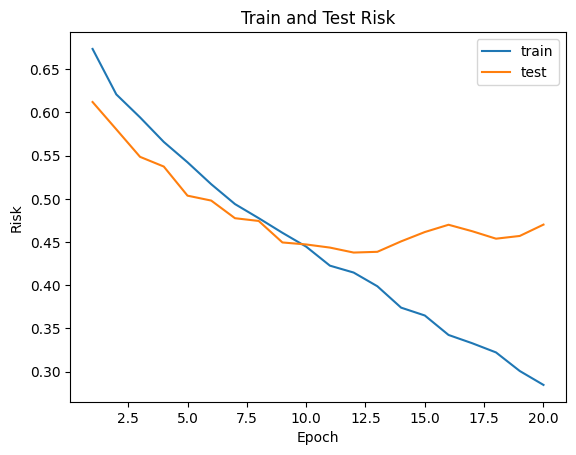

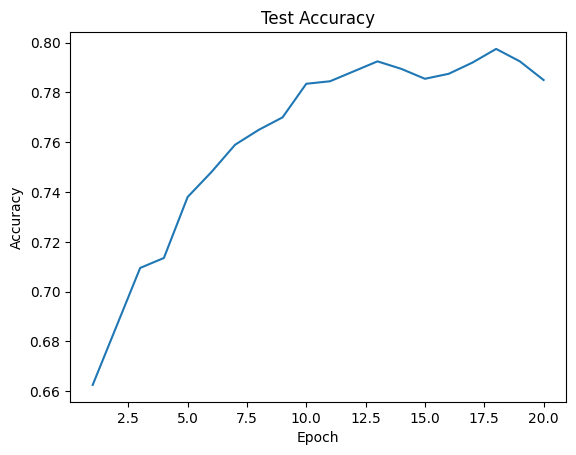

In [27]:
# Make an instant
model = myResNet_revised()
num_epochs = 20

train_risk, train_risk, test_accuracy =  train(model, num_epochs, device)

### ResNet with Only Batch Normalization
You may simply remove the dropouts, and try again training

In [30]:
class myResNet_onlyBN(nn.Module):
    def __init__(self):
        super(myResNet_onlyBN, self).__init__()
        # Layer 1: 3x3 Conv (3->32) -> BatchNorm2d -> ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        
        # Layer 2 (Residual Unit - First Conv): 3x3 Conv (32->32, stride 1, padding 1) -> BatchNorm2d -> ReLU
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        # Layer 3 (Residual Unit - Second Conv): 3x3 Conv (32->32, stride 1, padding 1) -> BatchNorm2d
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Layer 4: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 5: 6x6 Conv (32->64, no padding, stride 1) -> BatchNorm2d -> ReLU
        self.conv5 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        
        # Layer 6: Pooling 1/2 (MaxPool 2x2, stride 2)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 7: Fully-Connected (1600->128) -> BatchNorm1d -> ReLU
        self.fc7 = nn.Linear(5 * 5 * 64, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        
        # Layer 8: Fully-Connected (128->1) -> Sigmoid (binary classification)
        self.fc8 = nn.Linear(128, 1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        
        # L1: Conv -> BN -> ReLU
        x = self.conv1(x)
        out1 = self.relu1(self.bn1(x))
        
        # Residual Unit (L2 -> L3)
        # L2: Conv -> BN -> ReLU
        out_res = self.conv2(out1)
        out_res = self.relu2(self.bn2(out_res))
        
        # L3: Conv -> BN
        out_res = self.conv3(out_res)
        out_res = self.bn3(out_res)
        
        # Skip Connection and ReLU
        out_residual = out1 + out_res
        out_residual = self.relu2(out_residual)
        
        # L4: Pooling
        x = self.pool4(out_residual)
        
        # L5: 6x6 Conv -> BN -> ReLU
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        # L6: Pooling
        x = self.pool6(x)
        
        # Flatten
        x = x.view(-1, 5 * 5 * 64)
        
        # L7: FC -> BN -> ReLU
        x = self.fc7(x)
        x = self.relu7(self.bn7(x))
        
        # L8: FC -> Sigmoid
        x = self.sigmoid8(self.fc8(x))
        
        return x

Now repeat training

Epoch [2/20], Train Risk: 0.4893, Test Risk: 0.5284, Test Accuracy: 0.7275
Epoch [4/20], Train Risk: 0.3467, Test Risk: 0.5476, Test Accuracy: 0.7435
Epoch [6/20], Train Risk: 0.1879, Test Risk: 0.6629, Test Accuracy: 0.7495
Epoch [8/20], Train Risk: 0.0825, Test Risk: 0.7332, Test Accuracy: 0.7660
Epoch [10/20], Train Risk: 0.0364, Test Risk: 1.0045, Test Accuracy: 0.7580
Epoch [12/20], Train Risk: 0.0284, Test Risk: 1.1385, Test Accuracy: 0.7540
Epoch [14/20], Train Risk: 0.0141, Test Risk: 1.0891, Test Accuracy: 0.7740
Epoch [16/20], Train Risk: 0.0462, Test Risk: 1.4658, Test Accuracy: 0.7285
Epoch [18/20], Train Risk: 0.0395, Test Risk: 1.3393, Test Accuracy: 0.7365
Epoch [20/20], Train Risk: 0.0048, Test Risk: 1.0512, Test Accuracy: 0.7765


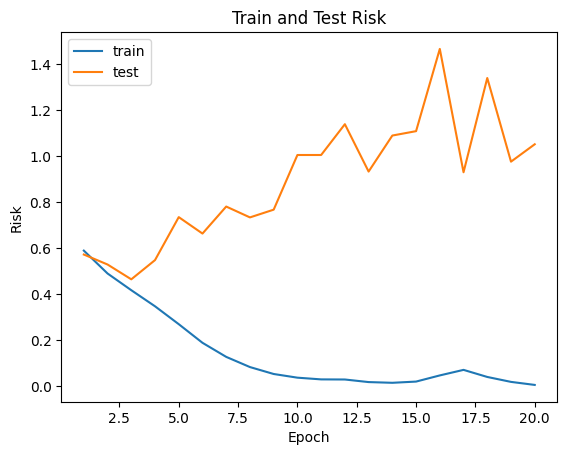

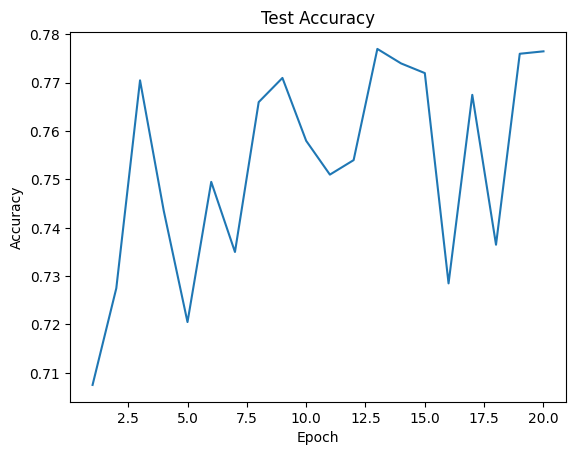

In [31]:
# Make an instant
model = myResNet_onlyBN()
num_epochs = 20

train_risk, train_risk, test_accuracy =  train(model, num_epochs, device)